!pip install -qq transformers
!pip install sentencepiece
!pip install -U huggingface_hub
!pip install datasets

In [ ]:
!pip install -qq transformers
!pip install sentencepiece
!pip install -U huggingface_hub
!pip install datasets

     |████████████████████████████████| 5.8 MB 8.0 MB/s 
     |████████████████████████████████| 182 kB 77.3 MB/s 
     |████████████████████████████████| 7.6 MB 81.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 8.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 8.1 MB/s 
     |████████████████████████████████| 132 kB 67.3 MB/s 
     |████████████████████████████████| 212 kB 77.1 MB/s 
     |████████████████████████████████| 127 kB 79.9 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
import transformers
from transformers import AutoModelForSequenceClassification, XLNetTokenizer, BertTokenizer
import pandas as pd
from datasets import load_dataset
import numpy as np
from datasets import Dataset
from transformers import TrainingArguments, Trainer
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sn


In [ ]:
#!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` now requires a token generated from https://huggingface.co/settings/tokens .
    
Token: 
Add token as git credential? (Y/n) n
n
Token is valid.
Your token has been saved to /root/.huggingface/token
Login successful


# **Data Cleaning** Use the twitter_mandeley.csv dataset for this part. After cleaning, you will recive a training and testing data.

In [ ]:
df = pd.read_csv("twitter_mendeley.csv")
df = df.rename(columns={'clean_text': 'content', 'category': 'label'})
print(df.shape)

(162980, 2)


In [ ]:
def light_clean(df, content):
  df[content] = df[content].str.replace('(\@\w+.*?)',"", regex=True)
  df[content] = df[content].str.replace(r'\s*https?://\S+(\s+|$)', ' ').str.strip()
  df = df[df[content].str.strip().astype(bool)]
  df = df.dropna()
  return df


In [ ]:
df = light_clean(df, "content")
print(df.shape)

<ipython-input-5-a39b84939577>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df[content] = df[content].str.replace(r'\s*https?://\S+(\s+|$)', ' ').str.strip()


(162968, 2)


In [ ]:
df.loc[df['label'] == "neg", 'label'] = 0
df.loc[df['label'] == "neu", 'label'] = 1
df.loc[df['label'] == "pos", 'label'] = 2
print(df.groupby("label").count())

       content
label         
0        35509
1        55210
2        72249


In [ ]:
df["label"] = df["label"].astype(int)
test_df = df.groupby("label").sample(n=1000) #stratified sampling 1000 each class
df = df.drop(test_df.index)
train_df = df.groupby("label").sample(n=3000) #stratified sampling 3000 each class

In [ ]:
#test_df.to_csv("test_mis515_set.csv")
#train_df.to_csv("train_mis515_set.csv")

In [ ]:
print(df.shape)
print(train_df.shape)
print(train_df.groupby("label").count())
print(test_df.shape)
print(test_df.groupby("label").count())
train_len = int(train_df["content"].str.len().max())
print(train_len)
test_len = int(test_df["content"].str.len().max())
print(test_len)

(159968, 2)
(9000, 2)
       content
label         
0         3000
1         3000
2         3000
(3000, 2)
       content
label         
0         1000
1         1000
2         1000
270
267


# **BERT**

*   training set: train_mis515_set.csv
*   testing set: test_mis515_set.csv



In [ ]:
train_df = pd.read_csv("train_mis515_set.csv")
test_df = pd.read_csv("test_mis515_set.csv")
train_df = train_df.sample(9000) #shuffle
test_df = test_df.sample(3000) #shuffle
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels= 3) #Load transformer

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["content"], padding="max_length", truncation=True, max_length = 280)
 
tokenized_datasets_train = train_dataset.map(tokenize_function, batched=True)
tokenized_datasets_test = test_dataset.map(tokenize_function, batched=True)
small_train_dataset = tokenized_datasets_train
small_eval_dataset = tokenized_datasets_test

  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

In [ ]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")

<ipython-input-13-56b0b4182bac>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis = 1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
from transformers import TrainingArguments, Trainer

#Look up hugging face documentation if you want to customize more of training arguemt
training_args = TrainingArguments(output_dir="mis_515_bert", 
                                  evaluation_strategy="epoch", 
                                  num_train_epochs=2, 
                                  learning_rate = 3e-5,
                                  push_to_hub=False) 

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train() #Train

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: content, __index_level_0__. If content, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 9000
  Num Epochs = 2
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2250
  Number of trainable parameters = 109484547


Epoch,Training Loss,Validation Loss,Accuracy
1,0.477300,0.374067,0.877667
2,0.270500,0.363581,0.907333


Saving model checkpoint to mis_515_bert/checkpoint-500
Configuration saved in mis_515_bert/checkpoint-500/config.json
Model weights saved in mis_515_bert/checkpoint-500/pytorch_model.bin
Saving model checkpoint to mis_515_bert/checkpoint-1000
Configuration saved in mis_515_bert/checkpoint-1000/config.json
Model weights saved in mis_515_bert/checkpoint-1000/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: content, __index_level_0__. If content, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3000
  Batch size = 8
Saving model checkpoint to mis_515_bert/checkpoint-1500
Configuration saved in mis_515_bert/checkpoint-1500/config.json
Model weights saved in mis_515_bert/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to mis_515_bert/checkpoint-2000
Confi

TrainOutput(global_step=2250, training_loss=0.43723617214626737, metrics={'train_runtime': 1070.2615, 'train_samples_per_second': 16.818, 'train_steps_per_second': 2.102, 'total_flos': 2590022705760000.0, 'train_loss': 0.43723617214626737, 'epoch': 2.0})

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: content, __index_level_0__. If content, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 3000
  Batch size = 8


              precision    recall  f1-score   support

           0       0.89      0.89      0.89      1000
           1       0.92      0.93      0.92      1000
           2       0.91      0.91      0.91      1000

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.91      0.91      0.91      3000



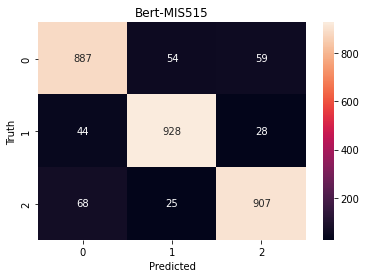

In [ ]:
output = trainer.predict(small_eval_dataset)
output = np.argmax(output[0], axis = 1)
cm = confusion_matrix(small_eval_dataset["label"], output)
sn.heatmap(cm, annot=True, fmt='d')
plt.title("Bert-MIS515")
plt.xlabel('Predicted')
plt.ylabel('Truth')
print(classification_report(small_eval_dataset["label"], output))

In [ ]:
#trainer.push_to_hub("mis515-bert")

# **XLNET**
*   training set: train_mis515_set.csv
*   testing set: test_mis515_set.csv

In [ ]:
train_df = pd.read_csv("train_mis515_set.csv").loc[:,["content", "label"]]
test_df = pd.read_csv("test_mis515_set.csv").loc[:,["content", "label"]]
print(train_df.groupby("label").count())
print(test_df.groupby("label").count())
train_df = train_df.sample(9000) #shuffle
test_df = test_df.sample(3000) #shuffle
print(train_df.isnull().sum())
print(test_df.isnull().sum())
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

       content
label         
0         3000
1         3000
2         3000
       content
label         
0         1000
1         1000
2         1000
content    0
label      0
dtype: int64
content    0
label      0
dtype: int64


In [ ]:
tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased", do_lower_case=True) #load tokenizer
model = AutoModelForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels= 3) #Load transformer

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

loading file spiece.model from cache at /root/.cache/huggingface/hub/models--xlnet-base-cased/snapshots/593a21e8b79948a7f952811aa44f37d76e23d586/spiece.model
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at None


Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--xlnet-base-cased/snapshots/593a21e8b79948a7f952811aa44f37d76e23d586/config.json
Model config XLNetConfig {
  "_name_or_path": "xlnet-base-cased",
  "architectures": [
    "XLNetLMHeadModel"
  ],
  "attn_type": "bi",
  "bi_data": false,
  "bos_token_id": 1,
  "clamp_len": -1,
  "d_head": 64,
  "d_inner": 3072,
  "d_model": 768,
  "dropout": 0.1,
  "end_n_top": 5,
  "eos_token_id": 2,
  "ff_activation": "gelu",
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-12,
  "mem_len": null,
  "model_type": "xlnet",
  "n_head": 12,
  "n_layer": 12,
  "pad_token_id": 5,
  "reuse_len": null,
  "same_length": false,
  "start_n_top": 5,
  "summary_activation": "tanh",
  "summary_last_dropout": 0.1,
  "summary_type": "last",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 250
    }
  },
  "transformers_version": "4.25.1",
  "untie_r":

Downloading:   0%|          | 0.00/467M [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--xlnet-base-cased/snapshots/593a21e8b79948a7f952811aa44f37d76e23d586/pytorch_model.bin
Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["content"], padding="max_length", truncation=True, max_length = 280)
 
tokenized_datasets_train = train_dataset.map(tokenize_function, batched=True)
tokenized_datasets_test = test_dataset.map(tokenize_function, batched=True)
small_train_dataset = tokenized_datasets_train
small_eval_dataset = tokenized_datasets_test

  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

In [ ]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis = 1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
training_args = TrainingArguments(output_dir="mis_515_xlnet", 
                                  evaluation_strategy="epoch", 
                                  num_train_epochs=2, 
                                  learning_rate = 5e-5,
                                  push_to_hub=False)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train() #Train

The following columns in the training set don't have a corresponding argument in `XLNetForSequenceClassification.forward` and have been ignored: content, Unnamed: 0. If content, Unnamed: 0 are not expected by `XLNetForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 9000
  Num Epochs = 2
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2250
  Number of trainable parameters = 117311235


Epoch,Training Loss,Validation Loss,Accuracy
1,0.531600,0.628448,0.813000
2,0.404700,0.590498,0.862000


Saving model checkpoint to mis_515_xlnet/checkpoint-500
Configuration saved in mis_515_xlnet/checkpoint-500/config.json
Model weights saved in mis_515_xlnet/checkpoint-500/pytorch_model.bin
Several commits (2) will be pushed upstream.
Saving model checkpoint to mis_515_xlnet/checkpoint-1000
Configuration saved in mis_515_xlnet/checkpoint-1000/config.json
Model weights saved in mis_515_xlnet/checkpoint-1000/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `XLNetForSequenceClassification.forward` and have been ignored: content, Unnamed: 0. If content, Unnamed: 0 are not expected by `XLNetForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3000
  Batch size = 8
Saving model checkpoint to mis_515_xlnet/checkpoint-1500
Configuration saved in mis_515_xlnet/checkpoint-1500/config.json
Model weights saved in mis_515_xlnet/checkpoint-1500/pytorch_model.bin
Saving model checkp

TrainOutput(global_step=2250, training_loss=0.5101764187282987, metrics={'train_runtime': 1744.8715, 'train_samples_per_second': 10.316, 'train_steps_per_second': 1.289, 'total_flos': 2804313506400000.0, 'train_loss': 0.5101764187282987, 'epoch': 2.0})

In [ ]:
#trainer.push_to_hub("mis515-xlnet")

Saving model checkpoint to mis_515_xlnet
Configuration saved in mis_515_xlnet/config.json
Model weights saved in mis_515_xlnet/pytorch_model.bin
Several commits (3) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 3.30k/448M [00:00<?, ?B/s]

Upload file runs/Dec14_02-27-08_bf5b3c6eb3dc/events.out.tfevents.1670984844.bf5b3c6eb3dc.76.2:  58%|#####8    …

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/Nhat1904/mis_515_xlnet
   8bd80d6..239fa97  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/Nhat1904/mis_515_xlnet
   8bd80d6..239fa97  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Text Classification', 'type': 'text-classification'}, 'metrics': [{'name': 'Accuracy', 'type': 'accuracy', 'value': 0.862}]}
To https://huggingface.co/Nhat1904/mis_515_xlnet
   239fa97..6dbf812  main -> main

   239fa97..6dbf812  main -> main



'https://huggingface.co/Nhat1904/mis_515_xlnet/commit/239fa9724540ed90b1160f01b48fd3c9d9fd211d'

The following columns in the test set don't have a corresponding argument in `XLNetForSequenceClassification.forward` and have been ignored: content, Unnamed: 0. If content, Unnamed: 0 are not expected by `XLNetForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 3000
  Batch size = 8


              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1000
           1       0.86      0.90      0.88      1000
           2       0.88      0.82      0.85      1000

    accuracy                           0.86      3000
   macro avg       0.86      0.86      0.86      3000
weighted avg       0.86      0.86      0.86      3000



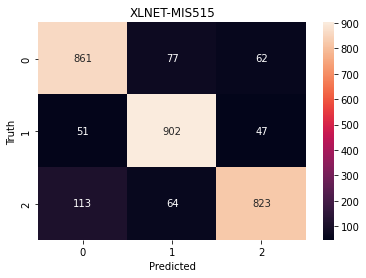

In [ ]:
output = trainer.predict(small_eval_dataset)
output = np.argmax(output[0], axis = 1)
cm = confusion_matrix(small_eval_dataset["label"], output)
sn.heatmap(cm, annot=True, fmt='d')
plt.title("XLNET-MIS515")
plt.xlabel('Predicted')
plt.ylabel('Truth')
print(classification_report(small_eval_dataset["label"], output))